<a href="https://colab.research.google.com/github/AnimeshBasak-14/Zillow-Home-Value-Zestimate-Prediction-/blob/main/ML_%7C_Zillow_Home_Value_(Zestimate)_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the necessary module and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')


Loading datasets and image folders


In [ ]:
df = pd.read_csv('Zillow.csv')
df.head()


FileNotFoundError: ignored

Displaying the first five records of labels dataset to see its attributes.



In [ ]:
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


Data Cleaning


In [ ]:
to_remove = []
for col in df.columns:

	# Removing columns having only one value.
	if df[col].nunique() == 1:
		to_remove.append(col)

	# Removing columns with more than 90% of the
	# rows as null values.
	elif (df[col].isnull()).mean() > 0.60:
		to_remove.append(col)

print(len(to_remove))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


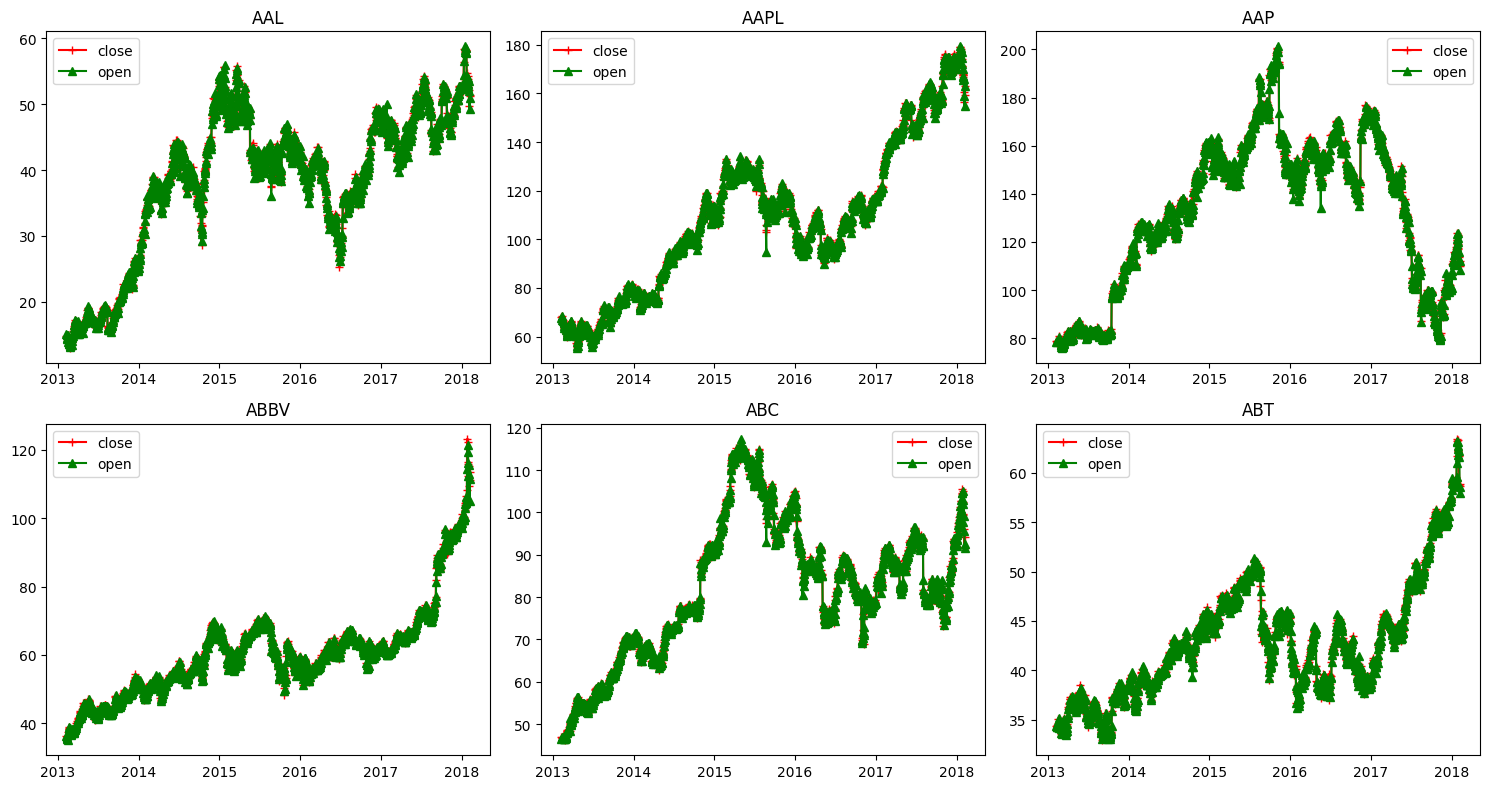

In [ ]:
df.drop(to_remove,
		axis=1,
		inplace=True)


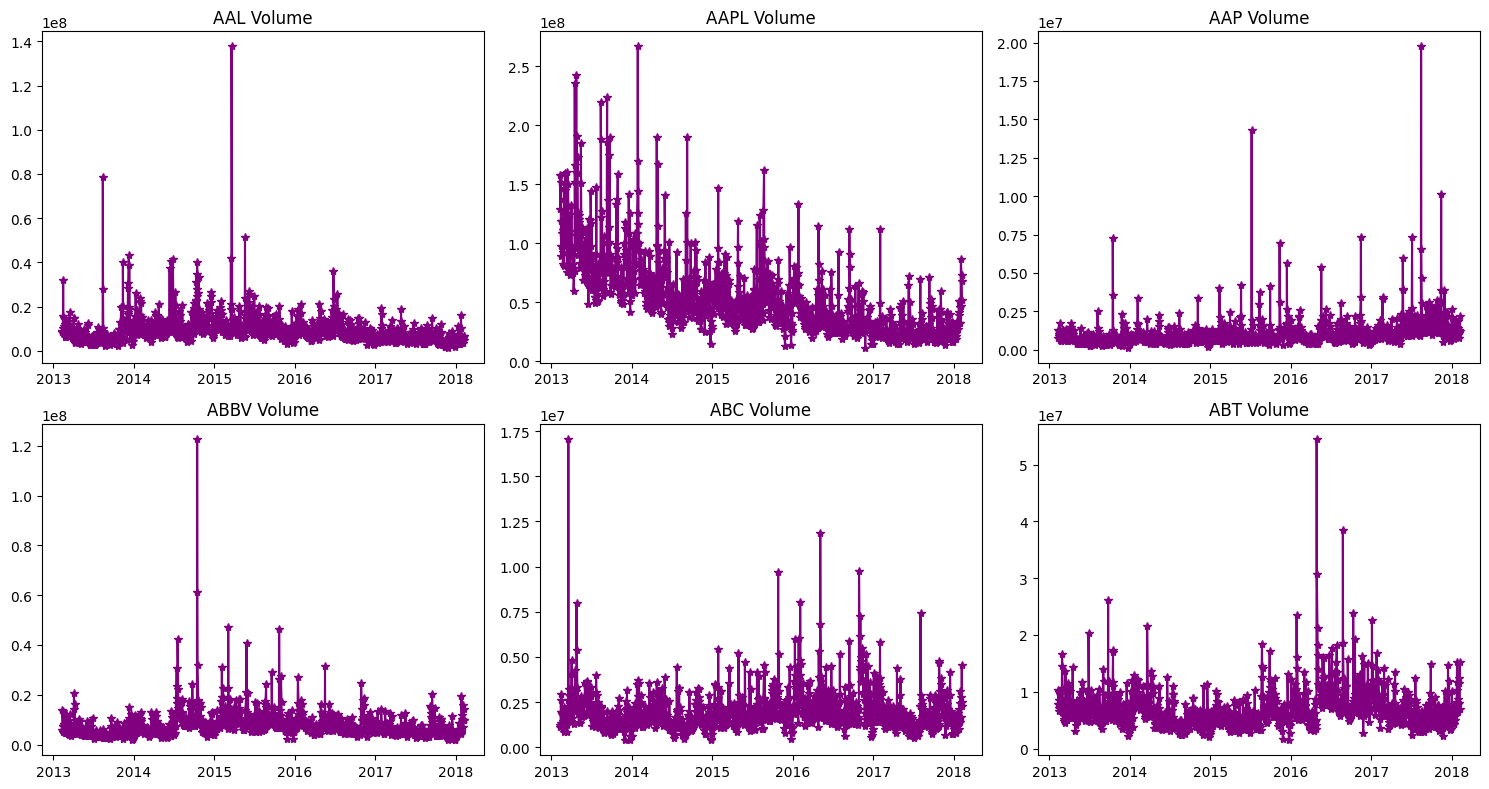

In [ ]:
df.info()


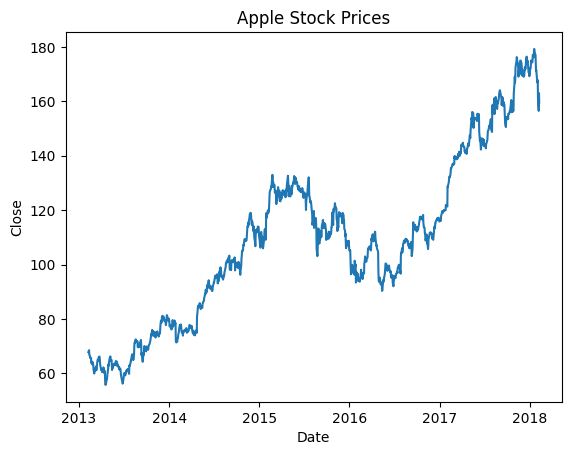

In [ ]:
df.isnull().sum().plot.bar()
plt.show()


In [ ]:
for col in df.columns:
	if df[col].dtype == 'object':
		df[col] = df[col].fillna(df[col].mode()[0])
	elif df[col].dtype == np.number:
		df[col] = df[col].fillna(df[col].mean())

df.isnull().sum().sum()


1197


Exploratory Data Analysis


In [ ]:
ints, objects, floats = [], [], []

for col in df.columns:
	if df[col].dtype == float:
		floats.append(col)
	elif df[col].dtype == int:
		ints.append(col)
	else:
		objects.append(col)

len(ints), len(floats), len(objects)


In [ ]:
for col in objects:
	print(col, ' -> ', df[col].nunique())
	print(df[col].unique())
	print()


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7d51d924ef20>>

In [ ]:
plt.figure(figsize=(8, 5))
sb.distplot(df['target'])
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sb.boxplot(df['target'])
plt.show()


In [ ]:
print('Shape of the dataframe before removal of outliers', df.shape)
df = df[(df['target'] > -1) & (df['target'] < 1)]
print('Shape of the dataframe after removal of outliers ', df.shape)


In [ ]:
for col in objects:
	le = LabelEncoder()
	df[col] = le.fit_transform(df[col])


In [ ]:
plt.figure(figsize=(15, 15))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()


In [ ]:
to_remove = ['calculatedbathnbr', 'fullbathcnt', 'fips',
			'rawcensustractandblock', 'taxvaluedollarcnt',
			'finishedsquarefeet12', 'landtaxvaluedollarcnt']

df.drop(to_remove, axis=1, inplace=True)


Model Training


In [ ]:
features = df.drop(['parcelid'], axis=1)
target = df['target'].values

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)
X_train.shape, X_val.shape


Epoch 1/10
36/36 [==============================] - 9s 94ms/step - loss: 0.0315
Epoch 2/10
36/36 [==============================] - 4s 102ms/step - loss: 0.0097
Epoch 3/10
36/36 [==============================] - 4s 102ms/step - loss: 0.0076
Epoch 4/10
36/36 [==============================] - 3s 84ms/step - loss: 0.0074
Epoch 5/10
36/36 [==============================] - 3s 79ms/step - loss: 0.0074
Epoch 6/10
36/36 [==============================] - 3s 85ms/step - loss: 0.0072
Epoch 7/10
36/36 [==============================] - 5s 151ms/step - loss: 0.0070
Epoch 8/10
36/36 [==============================] - 3s 98ms/step - loss: 0.0069
Epoch 9/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0068
Epoch 10/10
36/36 [==============================] - 3s 82ms/step - loss: 0.0061


In [ ]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


2/2 [==============================] - 1s 26ms/step
MSE 31.452972929946277
RMSE 5.608295010958881


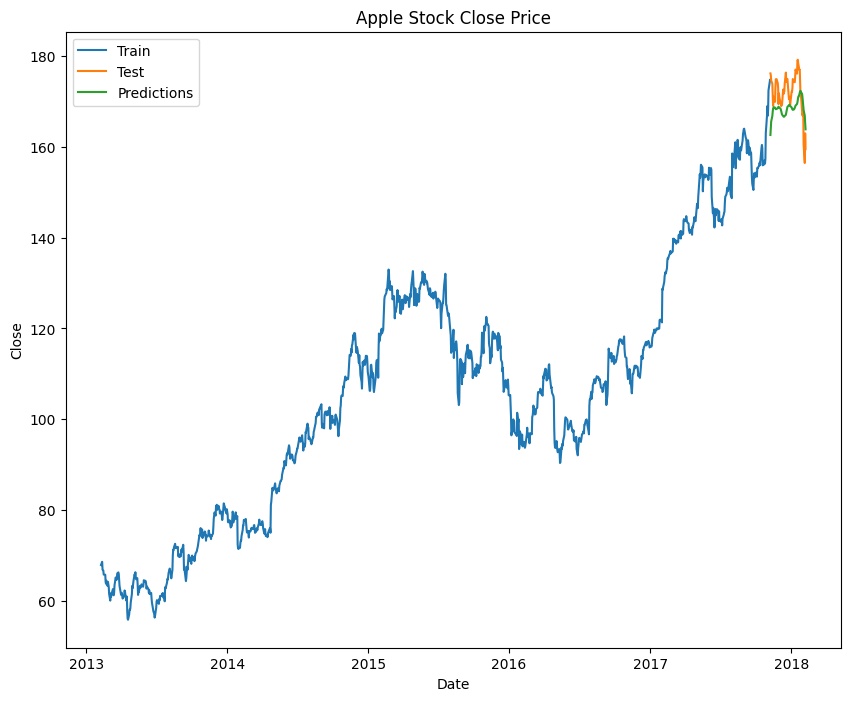

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),
		Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
	models[i].fit(X_train, Y_train)

	print(f'{models[i]} : ')

	train_preds = models[i].predict(X_train)
	print('Training Error : ', mae(Y_train, train_preds))

	val_preds = models[i].predict(X_val)
	print('Validation Error : ', mae(Y_val, val_preds))
	print()
